Dataset: https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset/download?datasetVersionNumber=1

Objective: Build a binary classifier that predicts if a bank’s customer is going to churn or not.

In [1]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from lazypredict.Supervised import LazyClassifier
from imblearn.over_sampling import SMOTE

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [2]:
# Read the dataset and display columns.
df_original = pd.read_csv('dataset/data.csv')
df_original.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# df.info() shows the data type of each column and the number of non-null values.
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [4]:
# df.describe() shows a statistical summary of the dataset.
df_original.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,15690940.57,650.53,38.92,5.01,76485.89,1.53,0.71,0.52,100090.24,0.20
std,71936.19,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.40
min,15565701.00,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,15628528.25,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,0.00
50%,15690738.00,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.91,0.00
75%,15753233.75,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.00
max,15815690.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00


From the dataset we can see that:
- The variable *customer_id* is a unique identifier for each customer.
- The variable *churn* is the target variable.
- The rest of the variables are either categorical or numerical.

In [5]:
# df.value_counts() shows the number of non-null values for each column.
print("Country value counts:")
print(df_original['country'].value_counts())
print("---------------------------------")
print("Gender value counts:")
print(df_original['gender'].value_counts())
print("---------------------------------")
print("Churn value counts:")
print(df_original['churn'].value_counts())

Country value counts:
country
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64
---------------------------------
Gender value counts:
gender
Male      5457
Female    4543
Name: count, dtype: int64
---------------------------------
Churn value counts:
churn
0    7963
1    2037
Name: count, dtype: int64


From the churn value counts we can see that the dataset is unbalanced, so we will use SMOTE to balance it and see if it helps.

In [6]:
# transform categorical data to numeric data
df = pd.get_dummies(df_original)
df.head()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_France,country_Germany,country_Spain,gender_Female,gender_Male
0,15634602,619,42,2,0.00,1,1,1,101348.88,1,True,False,False,True,False
1,15647311,608,41,1,83807.86,1,0,1,112542.58,0,False,False,True,True,False
2,15619304,502,42,8,159660.80,3,1,0,113931.57,1,True,False,False,True,False
3,15701354,699,39,1,0.00,2,0,0,93826.63,0,True,False,False,True,False
4,15737888,850,43,2,125510.82,1,1,1,79084.10,0,False,False,True,True,False


<Axes: >

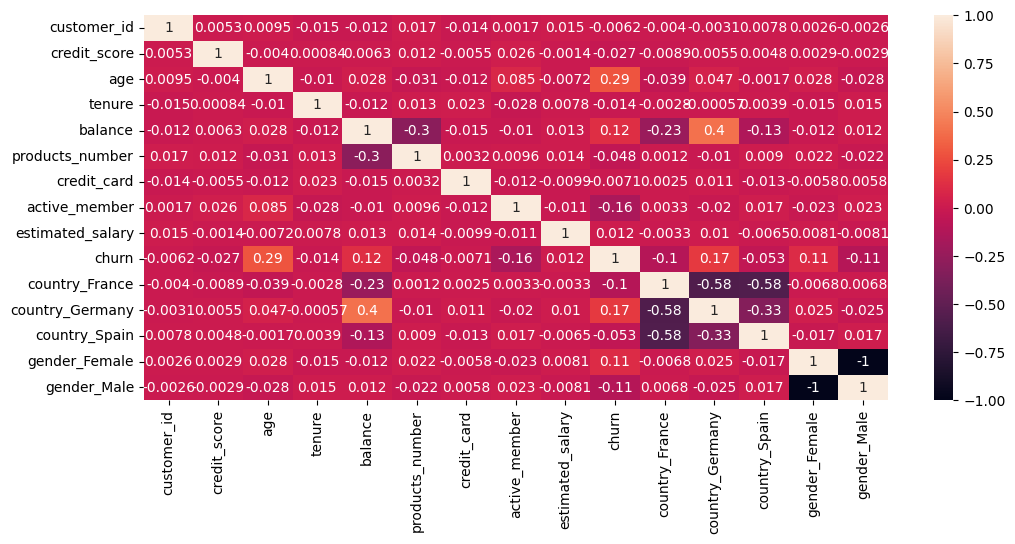

In [7]:
# We can calculate the correlation between the numeric features of the dataset.
# The result is a table with values between -1 and 1.
corr = df.corr(numeric_only=True)

# We can also plot the correlation between the numeric features of the dataset.
fig = plt.figure(figsize=(12, 5))
sns.heatmap(corr, annot=True)

In [8]:
# show the correlation of the target variable with the other variables
corr_target = corr['churn']

corr_target = corr_target.sort_values(ascending=False)
print(corr_target)

churn               1.00
age                 0.29
country_Germany     0.17
balance             0.12
gender_Female       0.11
estimated_salary    0.01
customer_id        -0.01
credit_card        -0.01
tenure             -0.01
credit_score       -0.03
products_number    -0.05
country_Spain      -0.05
country_France     -0.10
gender_Male        -0.11
active_member      -0.16
Name: churn, dtype: float64


*age* has the highest correlation with churn, so we can say that the older the customer is, the more likely he/she is to churn.

### Create training and test sets.

We can drop:
- *customer_id*, since it's unique for each customer.
- *gender_Male*, since it's opposite to *gender_Female*.

In [9]:
# We can use the drop() method to drop the columns that we don't need.
X = df.drop(['customer_id', 'gender_Male',  'churn'], axis=1)
y = df['churn']

X.shape

(10000, 12)

In [10]:
# We can use the train_test_split() method to split the dataset into training and testing sets.
# The test_size parameter specifies the percentage of the dataset that will be used for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,country_France,country_Germany,country_Spain,gender_Female
9254,686,32,6,0.00,2,1,1,179093.26,True,False,False,False
1561,632,42,4,119624.60,2,1,1,195978.86,False,True,False,False
1670,559,24,3,114739.92,1,1,0,85891.02,False,False,True,False
6087,561,27,9,135637.00,1,1,0,153080.40,True,False,False,True
6669,517,56,9,142147.32,1,0,0,39488.04,True,False,False,False


### Train a Machine Learning model to predict if a customer is going to churn.


In [11]:
# We can use the LazyClassifier() method to train all the models in the Scikit-learn library.
model = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None, predictions=True)

models, predictions = model.fit(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

100%|██████████| 29/29 [00:08<00:00,  3.48it/s]


We can print the results of each model with the following metrics:
- The Accuracy is the percentage of correct predictions.
- The Balanced Accuracy is the average of recall obtained on each class.
- The ROC AUC Score is the area under the ROC curve.
- The F1 score is the harmonic mean of precision and recall.

In [12]:
models.sort_values(by=['F1 Score'], ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.86,0.69,0.69,0.84,0.88
LGBMClassifier,0.86,0.69,0.69,0.84,0.10
AdaBoostClassifier,0.85,0.70,0.70,0.84,0.30
ExtraTreesClassifier,0.85,0.67,0.67,0.83,0.55
XGBClassifier,0.84,0.68,0.68,0.83,0.32
KNeighborsClassifier,0.84,0.69,0.69,0.83,0.10
SVC,0.85,0.66,0.66,0.83,1.16
BaggingClassifier,0.83,0.67,0.67,0.82,0.25
LabelSpreading,0.81,0.69,0.69,0.81,2.08


From the results we can see that even the DummyClassifier has an **Accuracy** of 0.80 because the dataset is unbalanced.

Showing the **Confusion Matrix** of one of the best models, the **RandomForestClassifier**.

Text(0.5, 23.52222222222222, 'Predicted Churn')

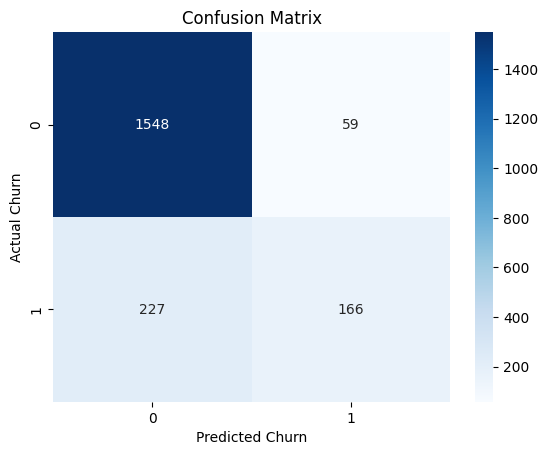

In [13]:
y_pred = predictions["RandomForestClassifier"]

conf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(conf_matrix), annot = True, cmap = 'Blues', fmt = 'g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Churn')
plt.xlabel('Predicted Churn')

From the confusion matrix we can see that the model is predicting well the customers that are not going to churn.
Since we got **212** false negative and only **60** false positive, we can say that the model is more inclined to predict that a customer is not going to churn. This is because the dataset is unbalanced.

So we try again by balancing the dataset using the function SMOTE.

The SMOTE function creates synthetic samples of the minority class by selecting samples that are close in the feature space.

In [14]:
smote = SMOTE(sampling_strategy = 'minority', random_state = 13)
X, y = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y.value_counts()

churn
1    7963
0    7963
Name: count, dtype: int64

In [15]:
model = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None, predictions=True)

models, predictions = model.fit(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

100%|██████████| 29/29 [00:23<00:00,  1.24it/s]


In [16]:
models.sort_values(by=['F1 Score'], ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.85,0.85,0.85,0.85,1.42
ExtraTreesClassifier,0.84,0.84,0.84,0.84,0.92
XGBClassifier,0.84,0.84,0.84,0.84,0.48
LGBMClassifier,0.84,0.84,0.84,0.84,0.11
BaggingClassifier,0.82,0.82,0.82,0.82,0.39
KNeighborsClassifier,0.81,0.81,0.81,0.81,0.16
NuSVC,0.81,0.81,0.81,0.81,4.87
SVC,0.81,0.81,0.81,0.81,3.41
AdaBoostClassifier,0.80,0.80,0.80,0.80,0.48


Now the DummyClassifier has an **Accuracy** of 0.50, which is what we would expect from a random classifier.

The accuracy of other models didn't change much, but the **Balanced Accuracy** and **ROC AUC Score** improved a LOT.

Since the accuracy isn't a good metric, we can check the confusion matrix to see how many false positives and false negatives we have.

Text(0.5, 23.52222222222222, 'Predicted Churn')

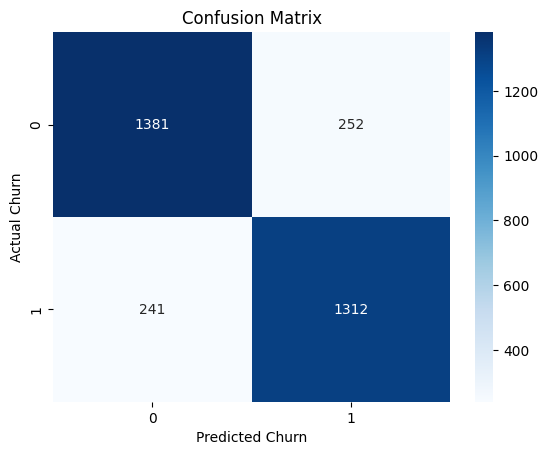

In [17]:
y_pred = predictions["RandomForestClassifier"]

conf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(conf_matrix), annot = True, cmap = 'Blues', fmt = 'g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Churn')
plt.xlabel('Predicted Churn')

Let's try now to find the best parameters for the RandomForestClassifier using GridSearchCV.

In [18]:
# We can use the GridSearchCV() method to find the best parameters for the model.
# The param_grid parameter specifies the parameters that will be tested.
# The scoring parameter specifies the metric that will be used to evaluate the model.
# The cv parameter specifies the number of folds in the cross-validation.
# The n_jobs parameter specifies the number of jobs to run in parallel.
model = RandomForestClassifier(random_state = 42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

grid_search = GridSearchCV(estimator = model, param_grid = param_grid, scoring = 'f1', cv = 5, n_jobs = -1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='f1')

We can now see the best parameters for the RandomForestClassifier and the best score.

In [19]:
grid_search.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [20]:
model = grid_search.best_estimator_
model.score(X_test, y_test)

0.8854362837413685

We got an accuracy score of **0.885** that is better than the previous one.
But as said before, the accuracy isn't a good metric, so we can check the confusion matrix to see how many false positives and false negatives we have.

Text(0.5, 23.52222222222222, 'Predicted Churn')

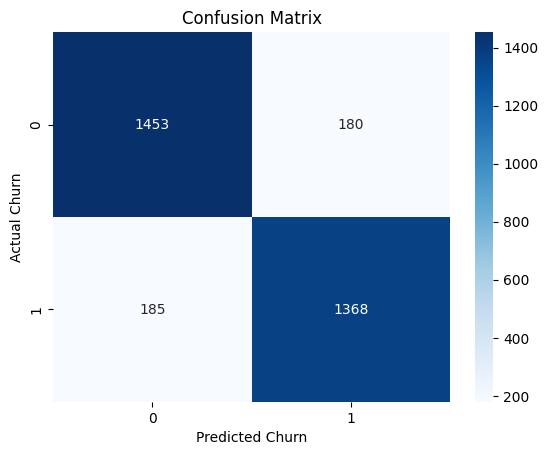

In [21]:
y_pred = model.predict(X_test)

conf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(conf_matrix), annot = True, cmap = 'Blues', fmt = 'g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Churn')
plt.xlabel('Predicted Churn')

We got now less false positives and false negatives than before, so we can say that the model is better.

We can now check what are the most important features for the model.

In [22]:
feature_importances = model.feature_importances_
feature_importances

array([0.09823907, 0.21662372, 0.06325005, 0.1144715 , 0.10099465,
       0.01871469, 0.09941041, 0.10504986, 0.03756733, 0.05775029,
       0.02940765, 0.05852077])

We're going to use ***Permutation Feature Importance*** because it doesn't have a bias toward high-cardinality features and can be computed on the test set.

In [23]:
result = permutation_importance(
    model, X_test, y_test, n_repeats=50, random_state=42, n_jobs=-1
)
feature_names = X.columns
forest_importances = pd.Series(result.importances_mean, index=feature_names)

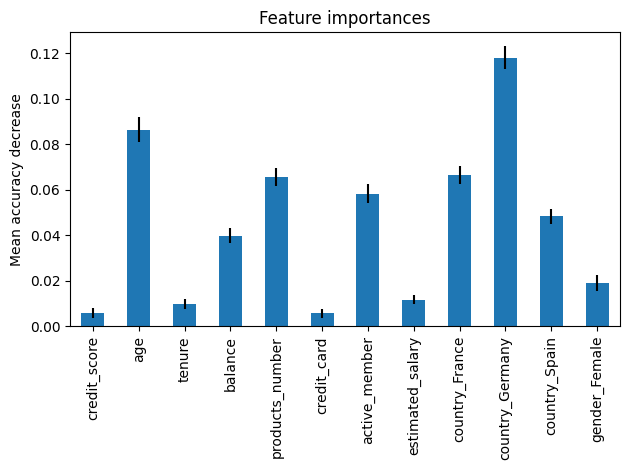

In [24]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [25]:
low_importance_features = forest_importances.sort_values(ascending=True).head(3).index
low_importance_features

Index(['credit_card', 'credit_score', 'tenure'], dtype='object')

Since these 3 features are the least important for the model, we can try to remove them and see if the model improves.

In [26]:
# drop the 3 least important features
X = X.drop(low_importance_features, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head()

,age,balance,products_number,active_member,estimated_salary,country_France,country_Germany,country_Spain,gender_Female
13555,48,0.00,2,1,49489.37,True,False,False,True
1665,42,129776.72,2,1,143538.51,True,False,False,False
14878,35,103705.78,1,0,193320.09,False,True,False,True
7471,55,119327.93,1,1,119439.66,False,True,False,True
2582,46,113402.14,2,1,138849.06,True,False,False,True


In [27]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='f1')

In [28]:
grid_search.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

In [29]:
model = grid_search.best_estimator_
model.score(X_test, y_test)

0.8797865662272442

We can see that the model accuracy decreased to **0.879**, so we can say that these 3 features are not important for the model.

In [30]:
result = permutation_importance(
    model, X_test, y_test, n_repeats=50, random_state=42, n_jobs=-1
)
feature_names = X.columns
forest_importances = pd.Series(result.importances_mean, index=feature_names)

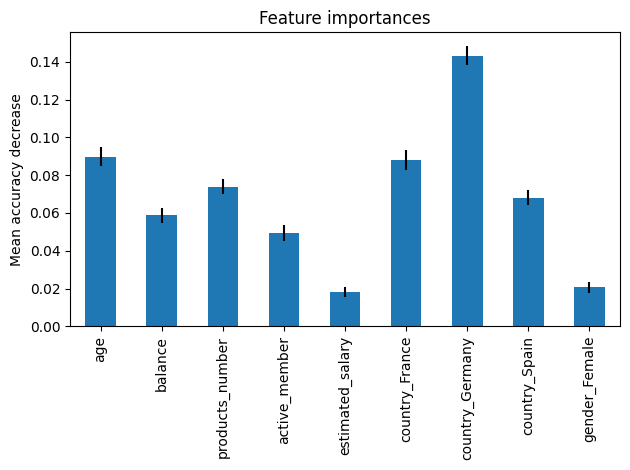

In [31]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()